In [1]:
from sklearn.metrics import recall_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import optuna
import pandas as pd

#load the preprocessed data
X_train = pd.read_csv("X_train_multi.csv")
X_test = pd.read_csv("X_test_multi.csv")
y_train = pd.read_csv("y_train_multi.csv").squeeze()
y_test = pd.read_csv("y_test_multi.csv").squeeze()
num_classes = 11

In [2]:
#dataframes to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [3]:
#Load the data to gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [4]:
#train and test sets loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [5]:
#loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

In [6]:
# Optuna study
study = optuna.create_study(direction='minimize')
num_epochs = 10

def objective(trial):
    # Define hyperparameters
    n_layers = trial.suggest_int('n_layers', 2, 5)
    hidden_sizes = [trial.suggest_int(f'units_l{i}', 10, 128) for i in range(n_layers)]
    dropout = trial.suggest_float('dropout', 0.2, 0.7)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [256, 512, 1024, 2048, 3000, 4096, 5000, 7500, 8192])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])

    # Build model
    layers = []
    in_features = X_train_tensor.shape[1]
    for units in hidden_sizes:
        layers.append(nn.Linear(in_features, units))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        in_features = units
    layers.append(nn.Linear(in_features, num_classes))  # Output layer for multi-class
    model = nn.Sequential(*layers).to(device)

    # Optimizer
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Data loaders with batch size based on Optuna suggestion
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Training phase
    model.train()
    for epoch in range(num_epochs):
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device).long()  # Ensure target is long/int for CrossEntropyLoss
            optimizer.zero_grad()
            outputs = model(xb)  # shape: [batch_size, num_classes]
            loss = loss_fn(outputs, yb)
            loss.backward()
            optimizer.step()

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device).long()
            outputs = model(xb)
            val_loss += loss_fn(outputs, yb).item() * xb.size(0)
    val_loss /= len(test_loader.dataset)

    return val_loss

# Run Optuna optimization
study.optimize(objective, n_trials=50)

[I 2025-05-29 18:49:02,331] A new study created in memory with name: no-name-c2abdb83-3fa1-4069-976b-d367583f1d27
[I 2025-05-29 18:51:21,776] Trial 0 finished with value: 0.18235142178342603 and parameters: {'n_layers': 3, 'units_l0': 21, 'units_l1': 41, 'units_l2': 69, 'dropout': 0.23043588085868955, 'lr': 0.0080818063615721, 'batch_size': 512, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.18235142178342603.
[I 2025-05-29 18:52:56,628] Trial 1 finished with value: 1.3556880884017803 and parameters: {'n_layers': 2, 'units_l0': 47, 'units_l1': 124, 'dropout': 0.2666853009522207, 'lr': 0.0002771077908011878, 'batch_size': 3000, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.18235142178342603.
[I 2025-05-29 18:54:28,217] Trial 2 finished with value: 0.006586400605879105 and parameters: {'n_layers': 2, 'units_l0': 73, 'units_l1': 56, 'dropout': 0.25044766505820204, 'lr': 0.003003037196296697, 'batch_size': 7500, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.00658640060587910

In [7]:
# Print best result
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value:  0.0025090400533955425
  Params: 
    n_layers: 3
    units_l0: 120
    units_l1: 92
    units_l2: 67
    dropout: 0.22675761337411485
    lr: 0.0008396370943424193
    batch_size: 1024
    optimizer: Adam


In [8]:
input_dim = X_train_tensor.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
layers = []
in_features = input_dim

for i in range(trial.params["n_layers"]):
    out_features = trial.params[f"units_l{i}"]
    layers.append(nn.Linear(in_features, out_features))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(trial.params["dropout"]))
    in_features = out_features

layers.append(nn.Linear(in_features, num_classes))  # Output layer with num_classes units
model_test = nn.Sequential(*layers).to(device)

In [10]:
#create the optimizer based on trial.params
if trial.params["optimizer"] == "Adam":
    optimizer = optim.Adam(model_test.parameters(), lr=trial.params["lr"])
elif trial.params["optimizer"] == "SGD":
    optimizer = optim.SGD(model_test.parameters(), lr=trial.params["lr"])
elif trial.params["optimizer"] == "RMSprop":
    optimizer = optim.RMSprop(model_test.parameters(), lr=trial.params["lr"])
else:
    raise ValueError(f"Unsupported optimizer: {trial.params['optimizer']}")

In [11]:
#create the dataloaders with the batch size from trial.params
train_loader = DataLoader(train_dataset, batch_size=trial.params["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=trial.params["batch_size"], shuffle=False)

In [12]:
criterion = nn.CrossEntropyLoss()  # For multi-class classification
epochs = 100

train_losses = []
val_losses = []
train_recalls = []
val_recalls = []

for epoch in range(epochs):
    # Training phase
    model_test.train()
    running_train_loss = 0.0
    train_preds = []
    train_targets = []

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).long().view(-1)  # Integer labels, 1D

        optimizer.zero_grad()
        outputs = model_test(X_batch)  # Shape: [batch_size, num_classes]
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * X_batch.size(0)

        preds = torch.argmax(outputs, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_targets.extend(y_batch.cpu().numpy())

    avg_train_loss = running_train_loss / len(train_loader.dataset)
    train_recall = recall_score(train_targets, train_preds, average='macro')
    train_losses.append(avg_train_loss)
    train_recalls.append(train_recall)

    # Validation phase
    model_test.eval()
    running_val_loss = 0.0
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).long().view(-1)

            outputs = model_test(X_batch)
            loss = criterion(outputs, y_batch)
            running_val_loss += loss.item() * X_batch.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(y_batch.cpu().numpy())

    avg_val_loss = running_val_loss / len(test_loader.dataset)
    val_recall = recall_score(val_targets, val_preds, average='macro')
    val_losses.append(avg_val_loss)
    val_recalls.append(val_recall)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {avg_train_loss} - Val Loss: {avg_val_loss} - "
          f"Train Recall: {train_recall} - Val Recall: {val_recall}")

Epoch 1/100 - Train Loss: 0.24457423885150592 - Val Loss: 0.02673586686027192 - Train Recall: 0.37459986893205993 - Val Recall: 0.5386585776377456
Epoch 2/100 - Train Loss: 0.022260471043630745 - Val Loss: 0.009639828662278806 - Train Recall: 0.5806073542699861 - Val Recall: 0.6275542778929316
Epoch 3/100 - Train Loss: 0.01146743963554345 - Val Loss: 0.006907513829691279 - Train Recall: 0.6503748365122958 - Val Recall: 0.719718802508307
Epoch 4/100 - Train Loss: 0.008011347075188297 - Val Loss: 0.004944201210518842 - Train Recall: 0.6981945900606102 - Val Recall: 0.7234307950085769
Epoch 5/100 - Train Loss: 0.006226129040011402 - Val Loss: 0.004636448517478789 - Train Recall: 0.7082448305939857 - Val Recall: 0.7240843455326056
Epoch 6/100 - Train Loss: 0.005552814548262521 - Val Loss: 0.0033728701154870193 - Train Recall: 0.7185443319828615 - Val Recall: 0.7239671138679451
Epoch 7/100 - Train Loss: 0.004988616575143053 - Val Loss: 0.0032965168737275 - Train Recall: 0.7215330491086541 -

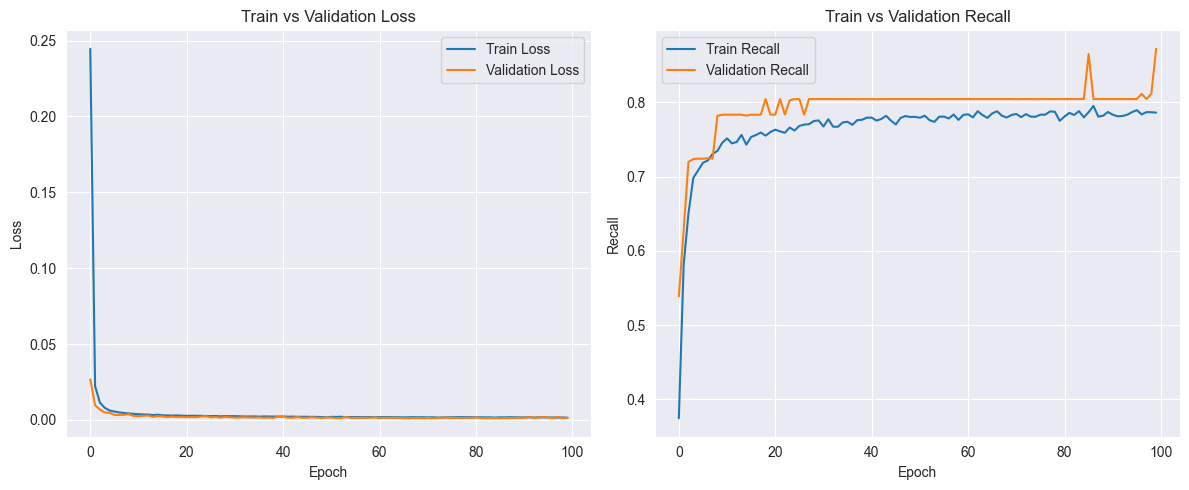

In [14]:
#display the final plots for losses and recalls
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)

# Plot recall
plt.subplot(1, 2, 2)
plt.plot(train_recalls, label='Train Recall')
plt.plot(val_recalls, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Train vs Validation Recall')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()